- I. Importation & Data Cleaning
- II. Aggregation & Visualisation
- III. Machine Learning Approach
- IV Basic Model Approach
- V. ARIMA approach (Autoregressive Integrated Moving Average)
- VI. (FB) Prophet Approach 
- VII. Comparaison & Conclusion

In [4]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

In [5]:
# Load the data
train = pd.read_csv("train_1.csv")


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [7]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [8]:
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)


In [9]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)


In [10]:
train_flattened.reset_index(drop=False,inplace=True)

In [11]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())


In [12]:
# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day


In [13]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,2,2016,11,16


This part allowed us to prepare our data. We had created new features that we use in the next steps. Days, Months, Years are interesting to forecast with a Machine Learning Approach or to do an analysis. If you have another idea to improve this first part: Fork this notebook and improve it or share your idea in the comments.


# Aggregation & Visualization

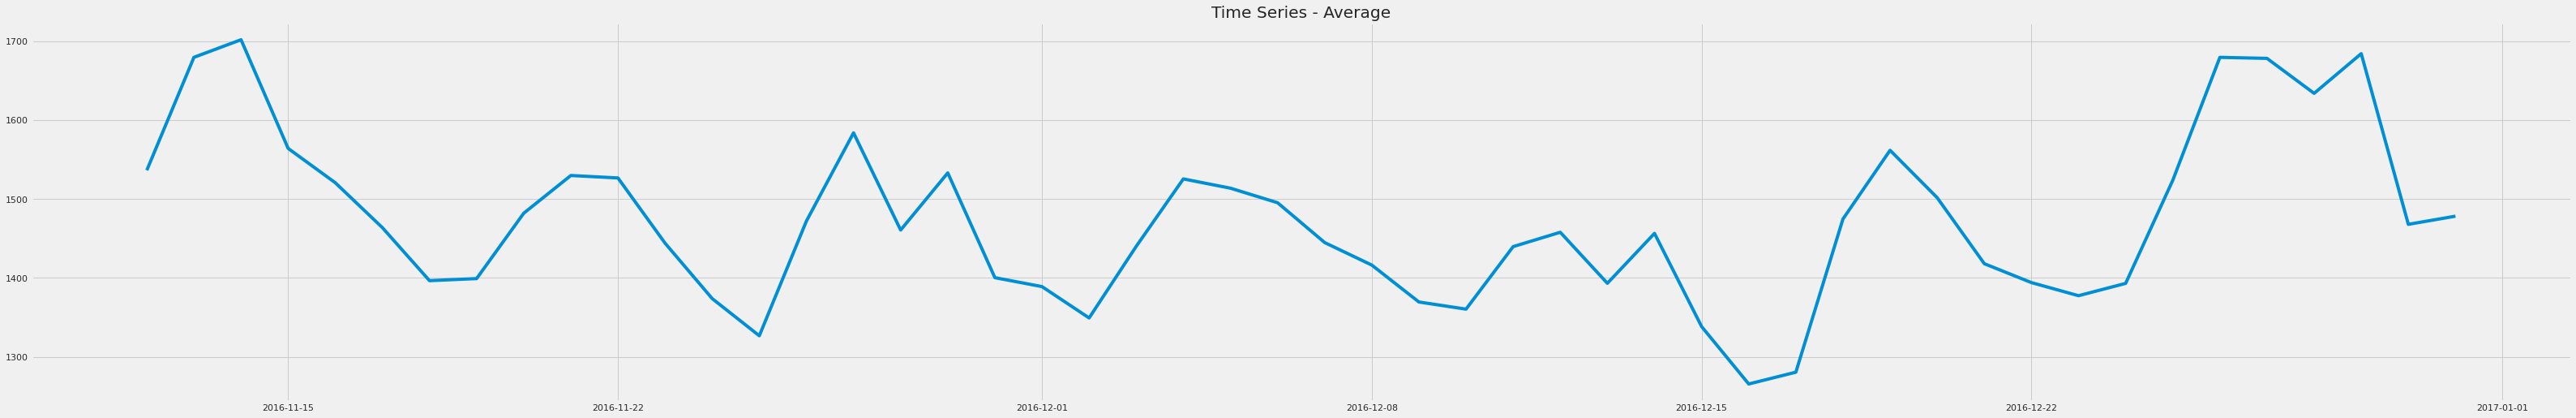

In [14]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()



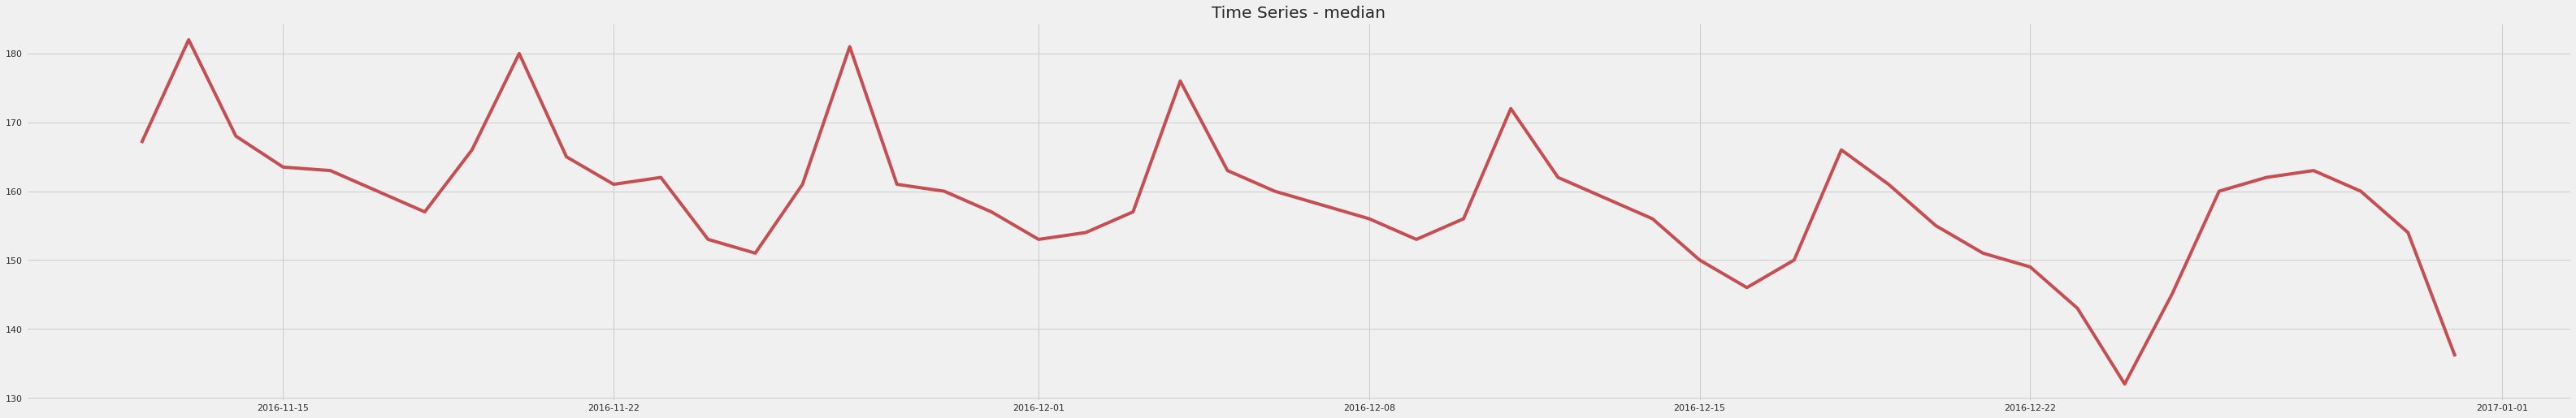

In [15]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()


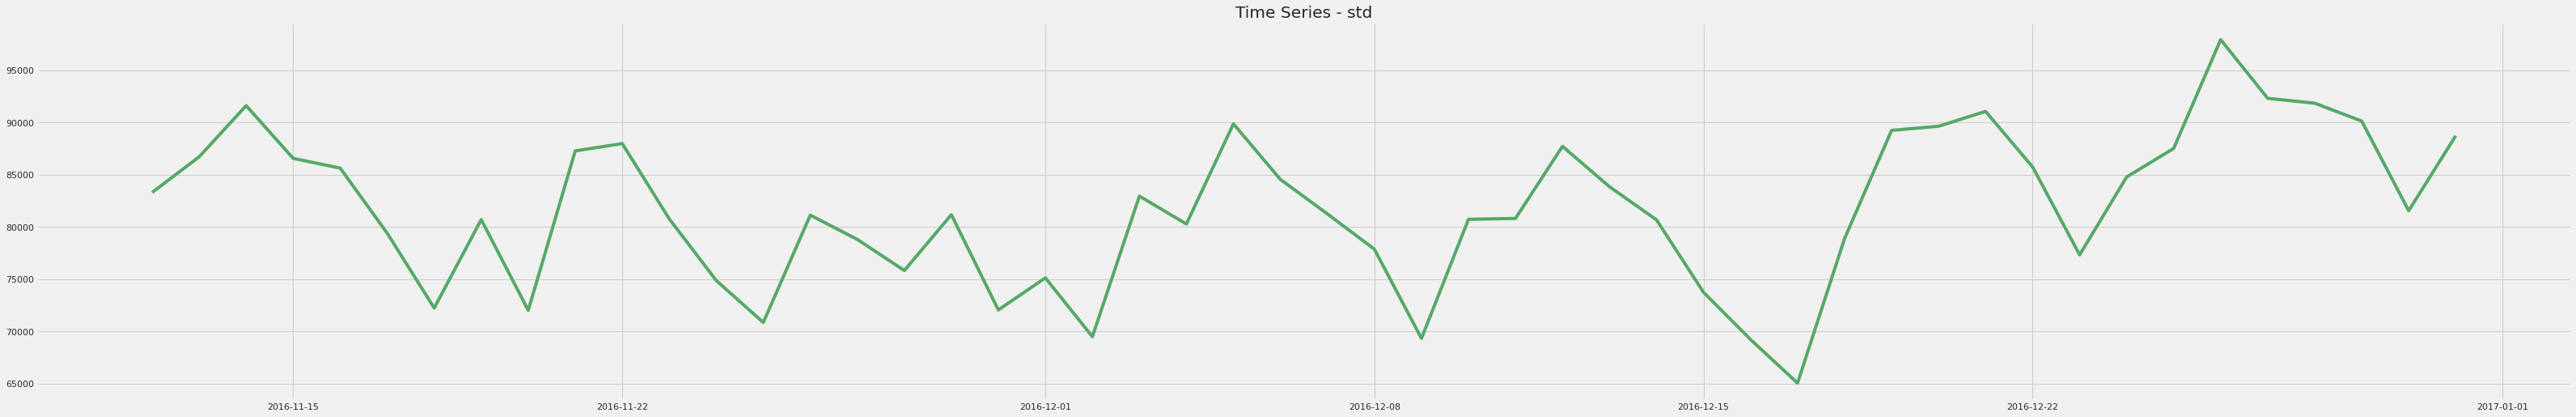

In [16]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()



In [17]:
# For the next graphics
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)



In [18]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)


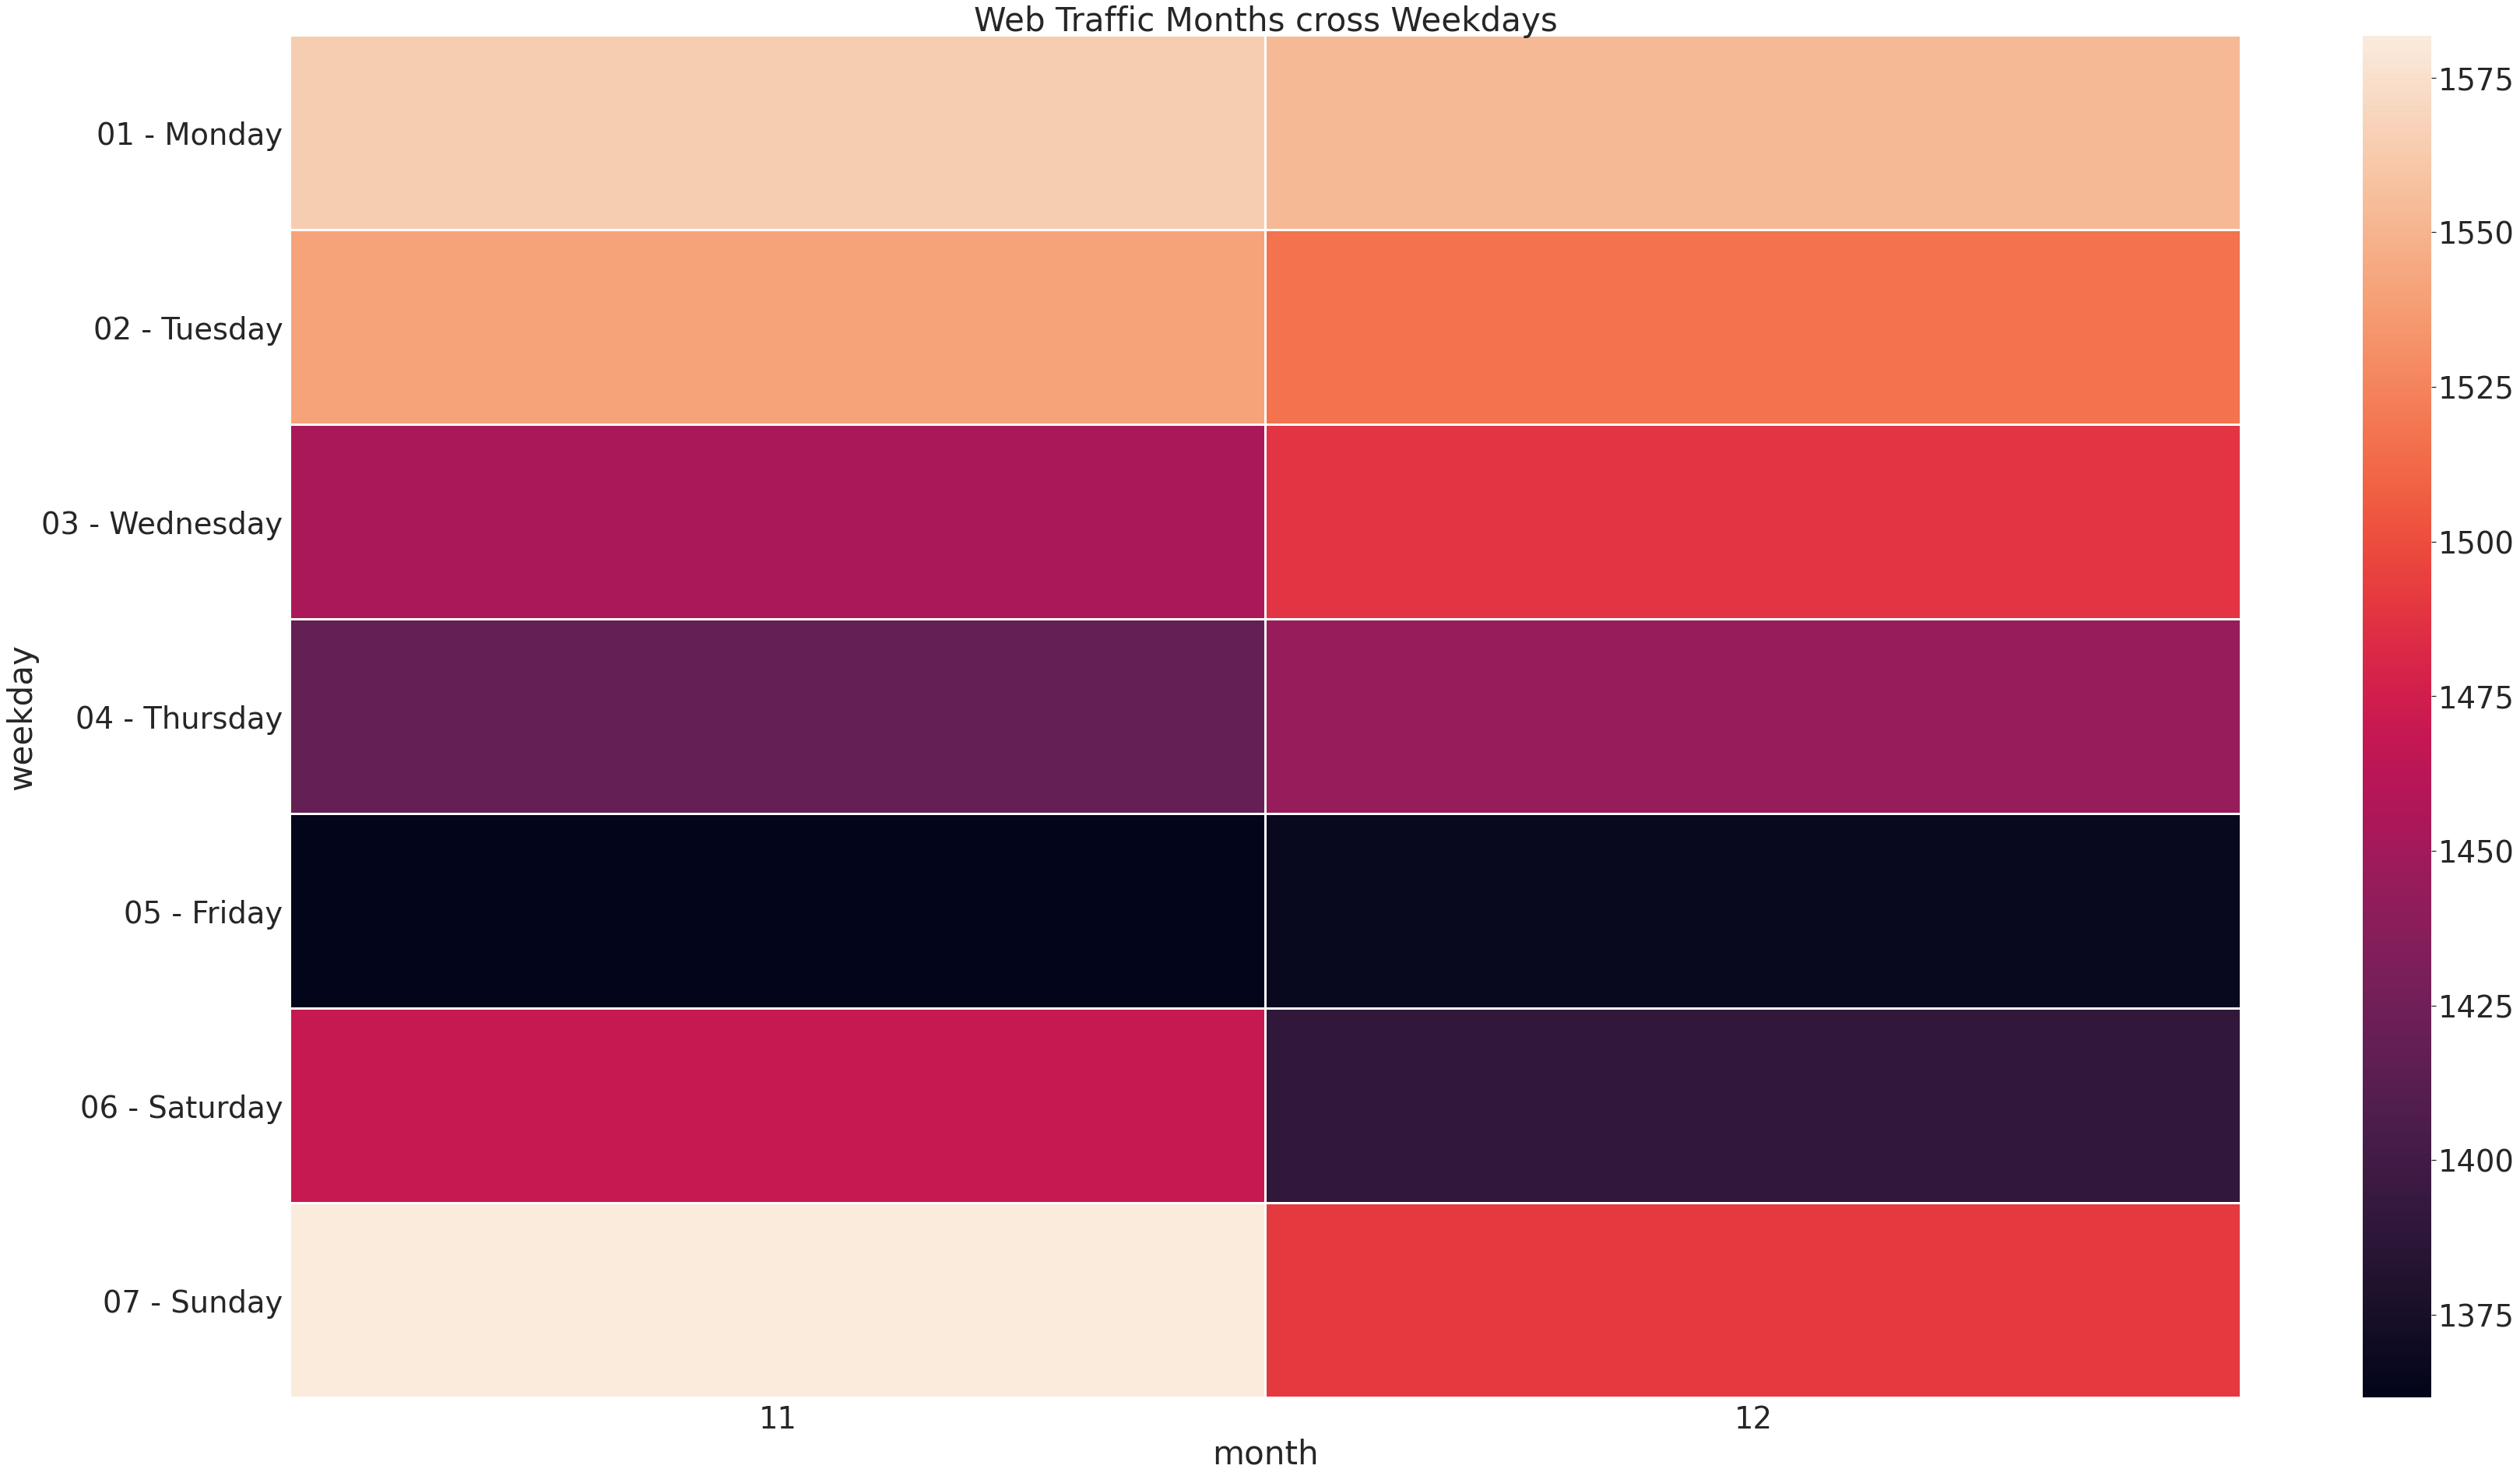

In [19]:
sns.set(font_scale=3.5) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()



This heatmap show us in average the web traffic by weekdays cross the months. In our data we can see there are less activity in Friday and Saturday for December and November. And the biggest traffic is on the period Monday - Wednesday. It is possible to do Statistics Test to check if our intuition is ok. But You have a lot of works !


In [20]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot('day','month','Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)


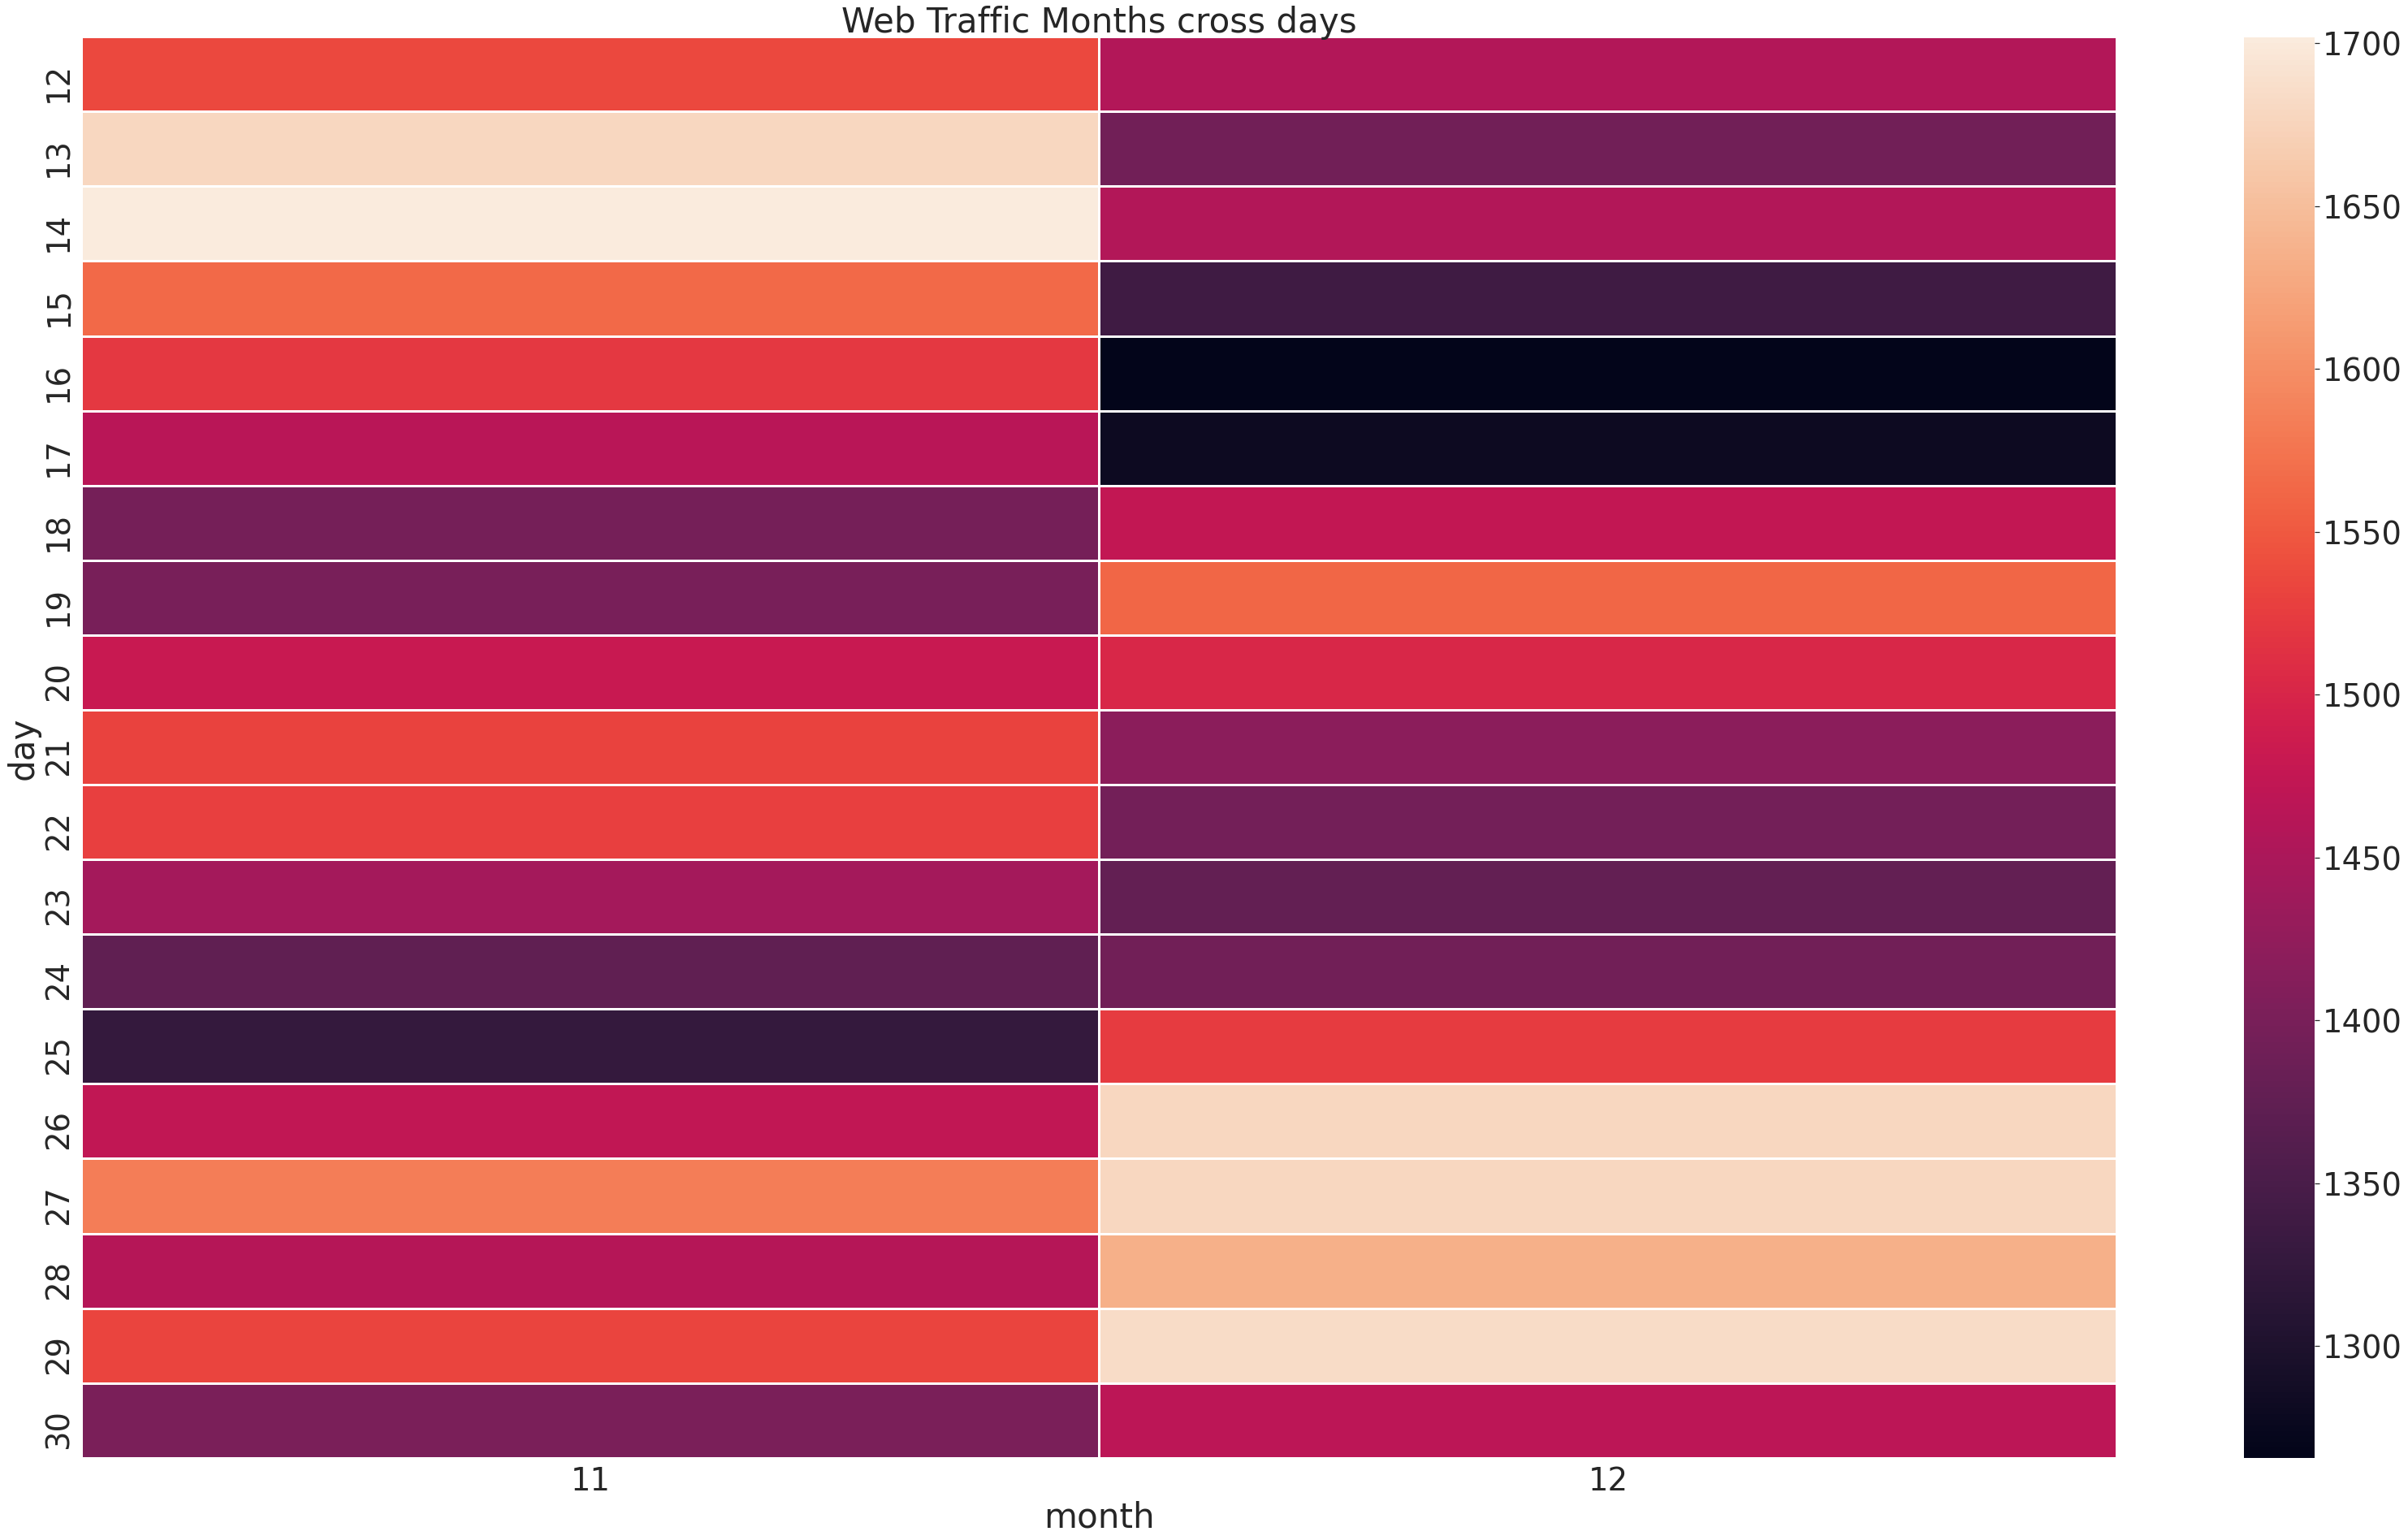

In [21]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()



With this graph it is possible to see they are two periods with a bigger activity than the rest. The two periods are 25-29 December and 13-14 November. And we can see one period with little activity 15-17 December. They are maybe few outliers during these two periods. You must to investigate more. (coming soon...)


# ML Approach

The first approach introduces is the Machine Learnin Approach. We will use just a AdaBoostRegressor but you can try with other models if you want to find the best model. I tried with a linear model as like Ridge but ADA model is better. I will be interesting to check if GB or XGB can bit ADA. It is possible to do a Neural Network approach too. But this approach will be done if the kagglers want more !!


In [22]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()


,date,Visits,weekday,year,month,day
0,2016-11-12,1536.471757,5,2016,11,12
1,2016-11-13,1679.630589,6,2016,11,13
2,2016-11-14,1701.941831,0,2016,11,14
3,2016-11-15,1564.172228,1,2016,11,15
4,2016-11-16,1520.673959,2,2016,11,16


The first step for the ML approach is to create the feature that we will predict. In our example we don't predict the number of visits but the difference between two days. The tips to create few features is to take the difference between two days and to do a lag. Here we will take a lag of "diff" seven times. If you have a weekly pattern it is an interesting choice. Here we have few data (2 months so 30 values) and it is a contraint. I done some test and the number 7 is a good choice (weekly pattern?).


In [23]:
times_series_means.reset_index(drop=True,inplace=True)

def lag_func(data,lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.loc[1:, "diff"] = (data.iloc[1:, 1].to_numpy() - data.iloc[:len(data)-1, 1].to_numpy())
    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count,lag)
last_date = lagged['date'].max()

In [24]:
lagged.head()


,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-11-12,1536.471757,5,2016,11,12,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2016-11-13,1679.630589,6,2016,11,13,143.158833,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2016-11-14,1701.941831,0,2016,11,14,22.311241,143.158833,NaN,0.000000,0.0,0.0,0.0,0.0
3,2016-11-15,1564.172228,1,2016,11,15,-137.769602,22.311241,143.158833,NaN,0.0,0.0,0.0,0.0
4,2016-11-16,1520.673959,2,2016,11,16,-43.498270,-137.769602,22.311241,143.158833,NaN,0.0,0.0,0.0


In [25]:
# Train Test split
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)


In [26]:
# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Modelisation with all product
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.to_numpy(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.to_numpy(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("made with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    # Model with all data
    model1.fit(xt, yt) 
    
    return model1, prediction, model0

model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

clr, prediction, clr0  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)


-----------------------------------------------
made with 70% of the data to train: 77.35881695062493
-----------------------------------------------


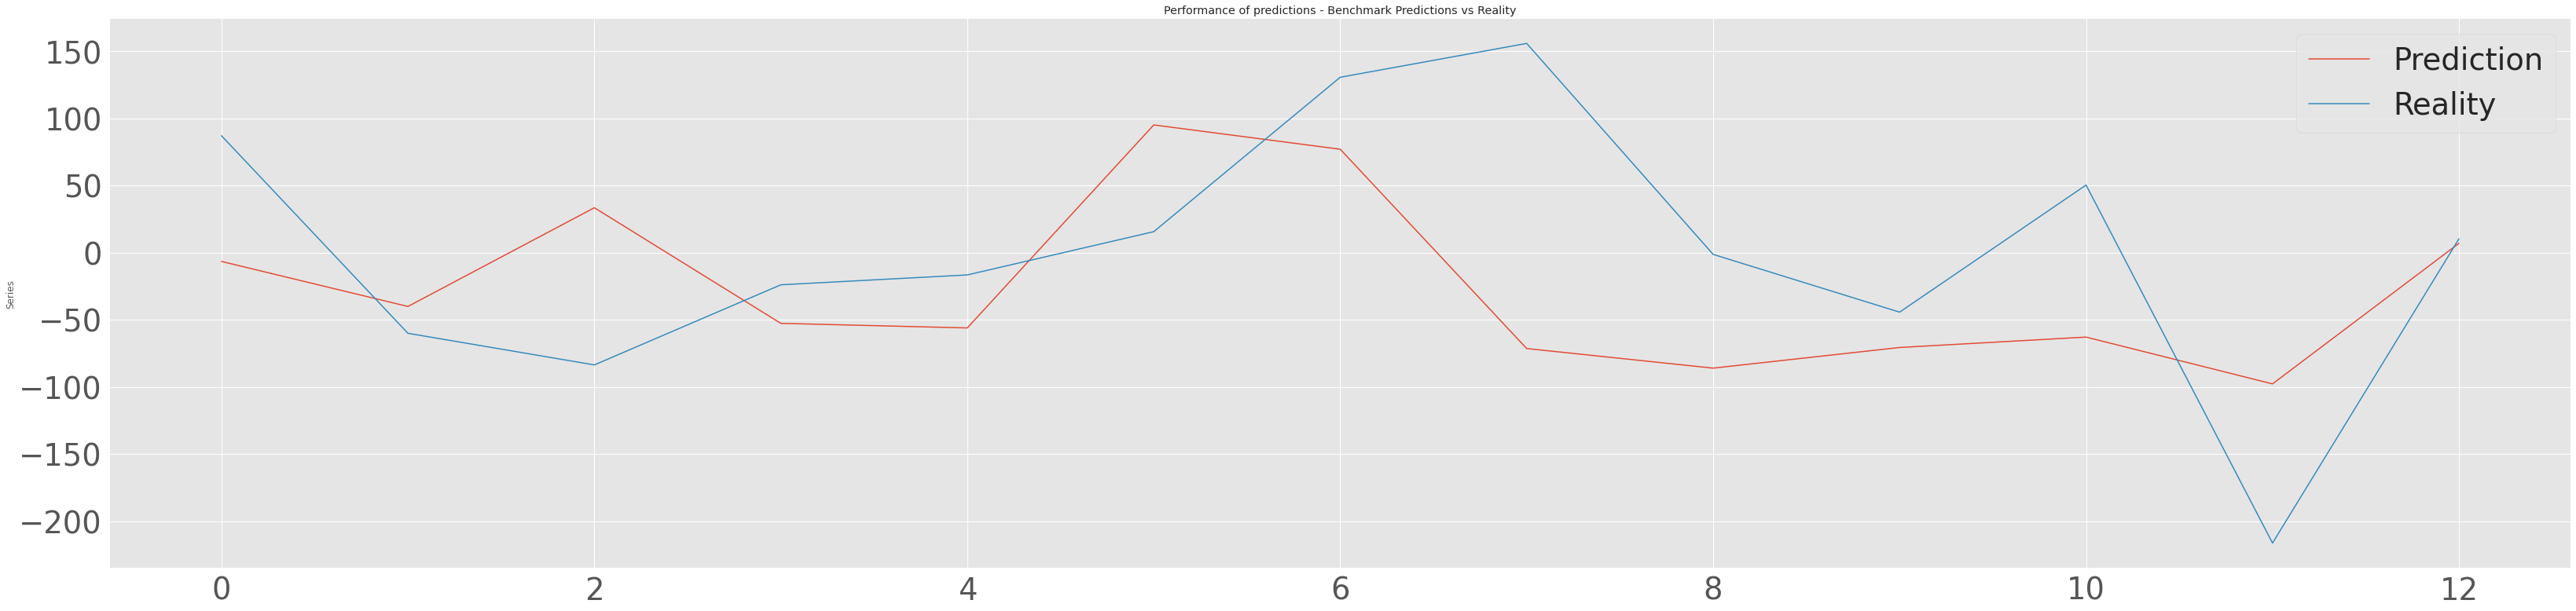

In [27]:
# Performance 1
plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()


In [28]:
# Prediction
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)


In [29]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    # Initialisation
    model.fit(xtrain, ytrain)
    
    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]
        
        data_pred['weekday'] = data_pred['date'].apply(lambda x:x.weekday())
        weekday = data_pred['weekday'][0]
        
        row = pd.Series([lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,weekday]
                        ,['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        to_predict = pd.DataFrame(columns = ['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        prediction = pd.DataFrame(columns = ['diff'])
        to_predict = to_predict.append([row])
        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff'])

        # Loop
        if i == 0:
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]

        if i > 0 :
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]
        
        data_lag = pd.concat([data_lag,prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["Visits"][data_lag.shape[0]-1] = last_predict
        
        # test
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)
        
    return data_lag

model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)


In [30]:
lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)

In [31]:
lagged[lagged['diff']<0]
lagged.loc[(lagged.Visits < 0), 'Visits'] = 0


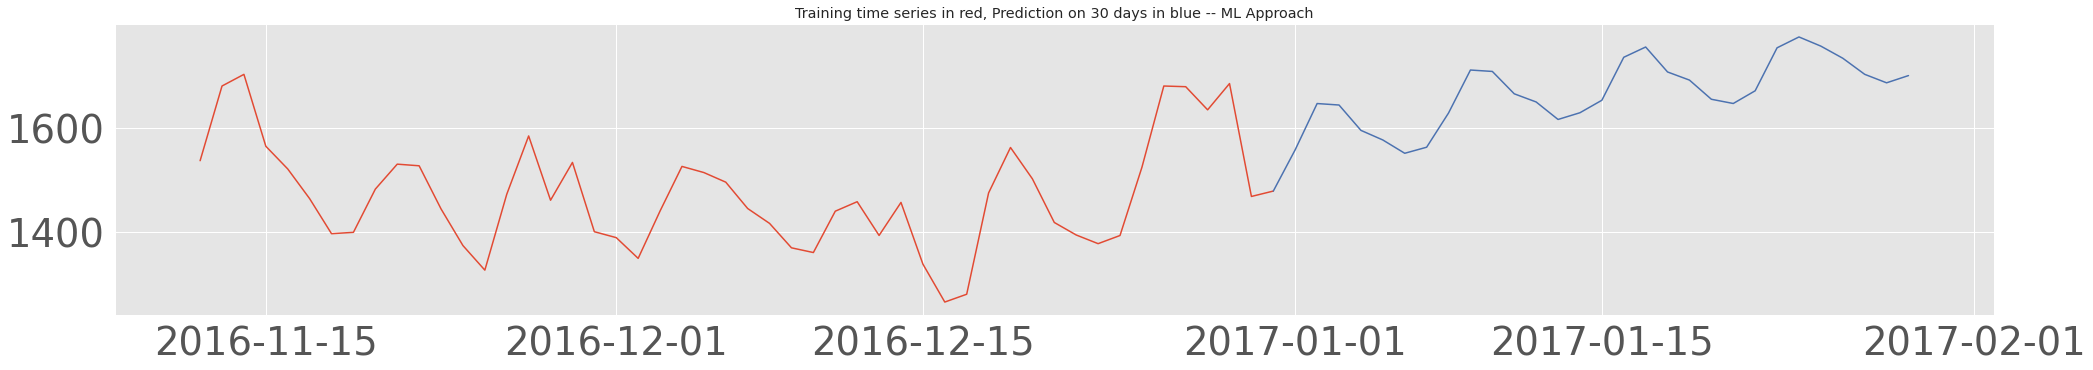

In [32]:
df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()
    


Finshed for the first approach ! The ML method requires a lot of work ! You need to create the features, the data to collect the prediction, optimisation etc... This method done a good results when there are a weekly pattern identified or a monthly pattern but we need more data.


In [33]:
lagged_basic = lagged[['date','Visits','weekday']]
lagged_basic_tr   = lagged_basic[lagged_basic['date'] < last_date]
lagged_basic_pred = lagged_basic[lagged_basic['date'] >= last_date]
lagged_basic_pred.drop('Visits',inplace=True,axis=1)



In [34]:
prediction_by_days = pd.DataFrame(lagged_basic.groupby(['weekday'])['Visits'].mean())
prediction_by_days.reset_index(drop=False,inplace=True)
prediction_by_days


,weekday,Visits
0,0.0,1613.573222
1,1.0,1597.393782
2,2.0,1549.115941
3,3.0,1518.968685
4,4.0,1461.408287
5,5.0,1490.224871
6,6.0,1576.416959


In [35]:
basic_pred = pd.merge(lagged_basic_pred,prediction_by_days,on='weekday')
basic_approach = pd.concat([lagged_basic_tr,basic_pred])



In [36]:
plot_basic = np.array(basic_approach[basic_approach['date'] > last_date].sort_values(by='date').Visits)



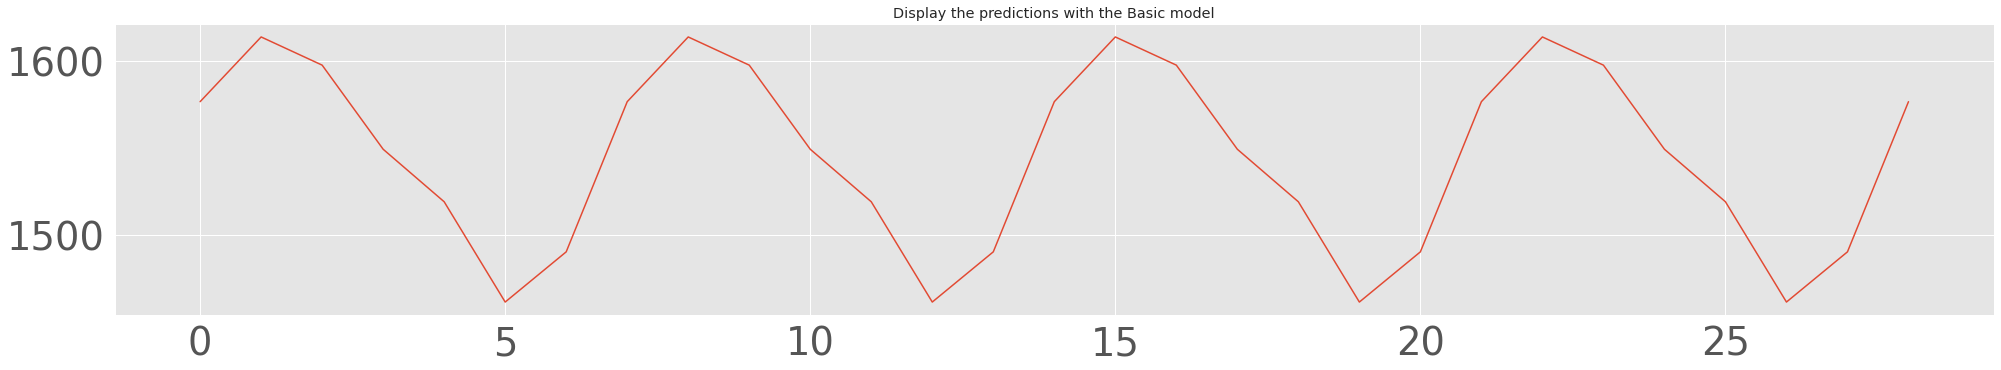

In [37]:
plt.figure(figsize=(30, 5))
plt.plot(plot_basic)
plt.title('Display the predictions with the Basic model')
plt.show()


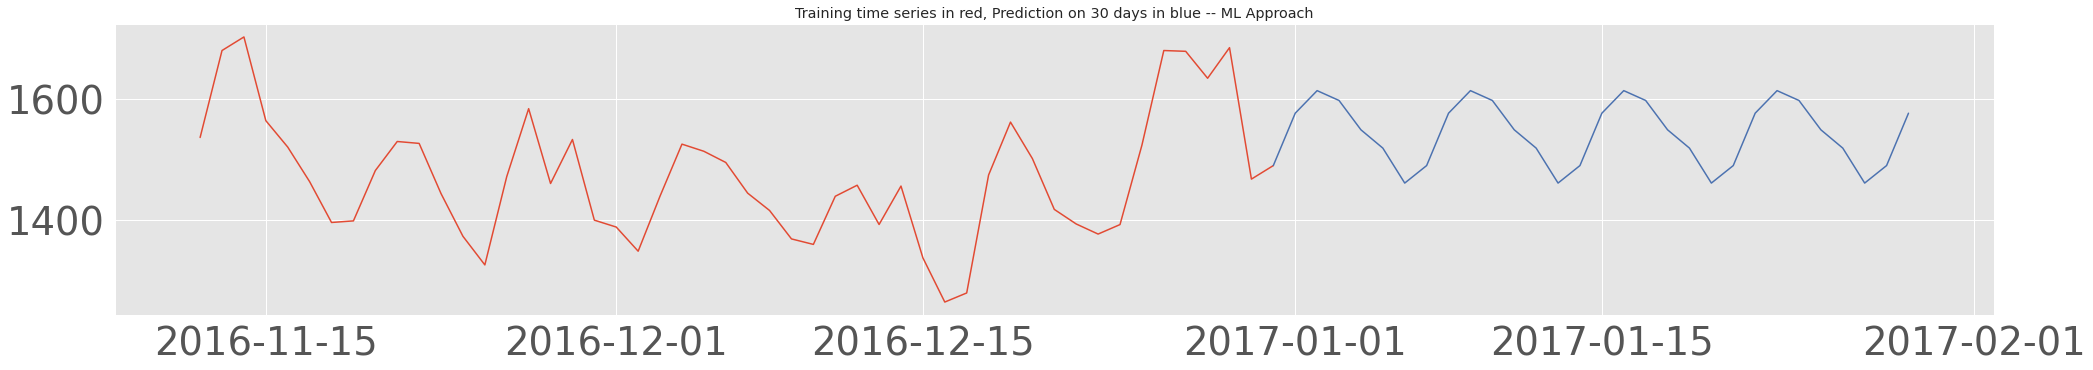

In [38]:
df_lagged = basic_approach[['Visits','date']].sort_values(by='date')
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()
    

# ARIMA

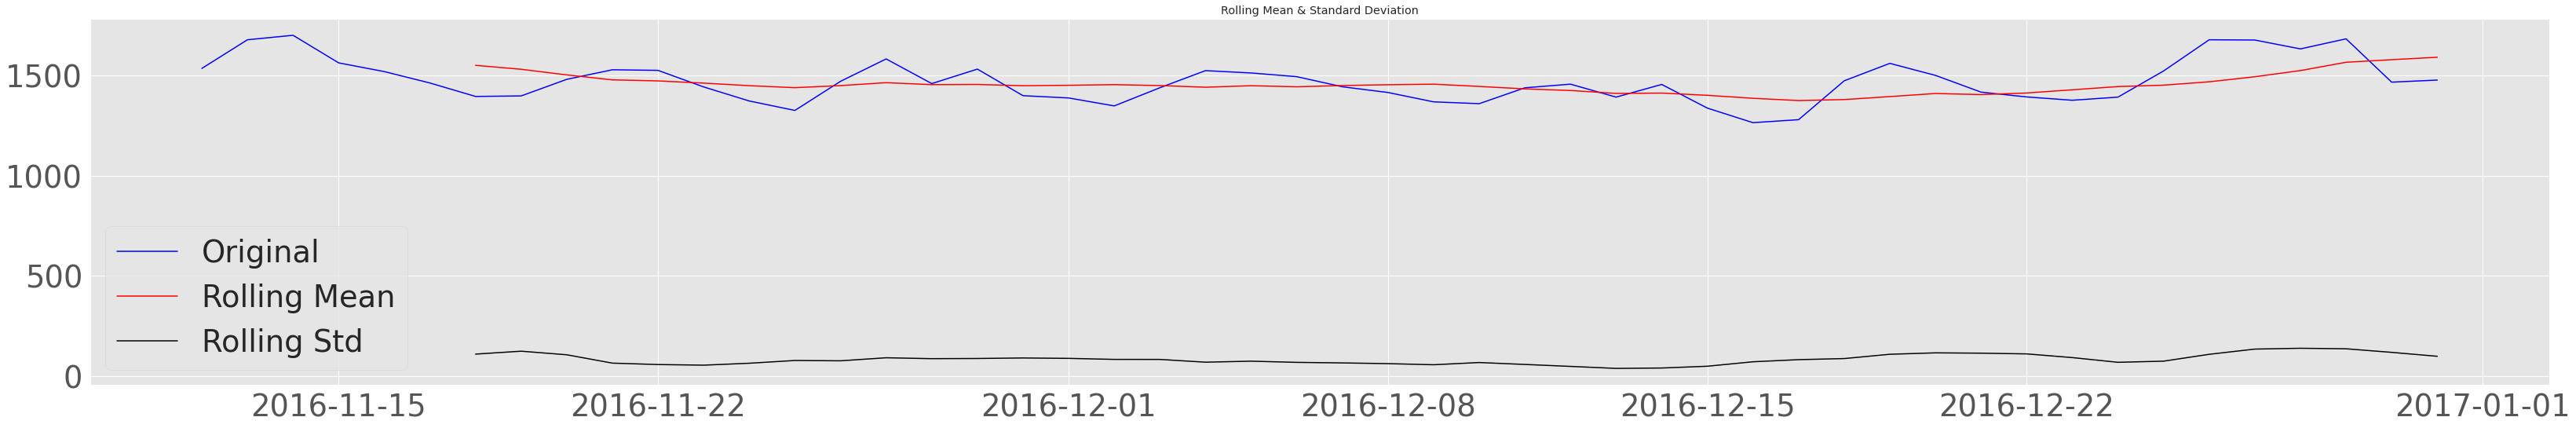

Results of Dickey-Fuller Test:
Test Statistic                 -4.292839
p-value                         0.000457
#Lags Used                      1.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [39]:
# Show Rolling mean, Rolling Std and Test for the stationnarity
df_date_index = times_series_means[['date','Visits']].set_index('date')

def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['Visits'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)   


Our Time Series is stationary ! Thus, we can to apply the ARIMA Model without transformations.

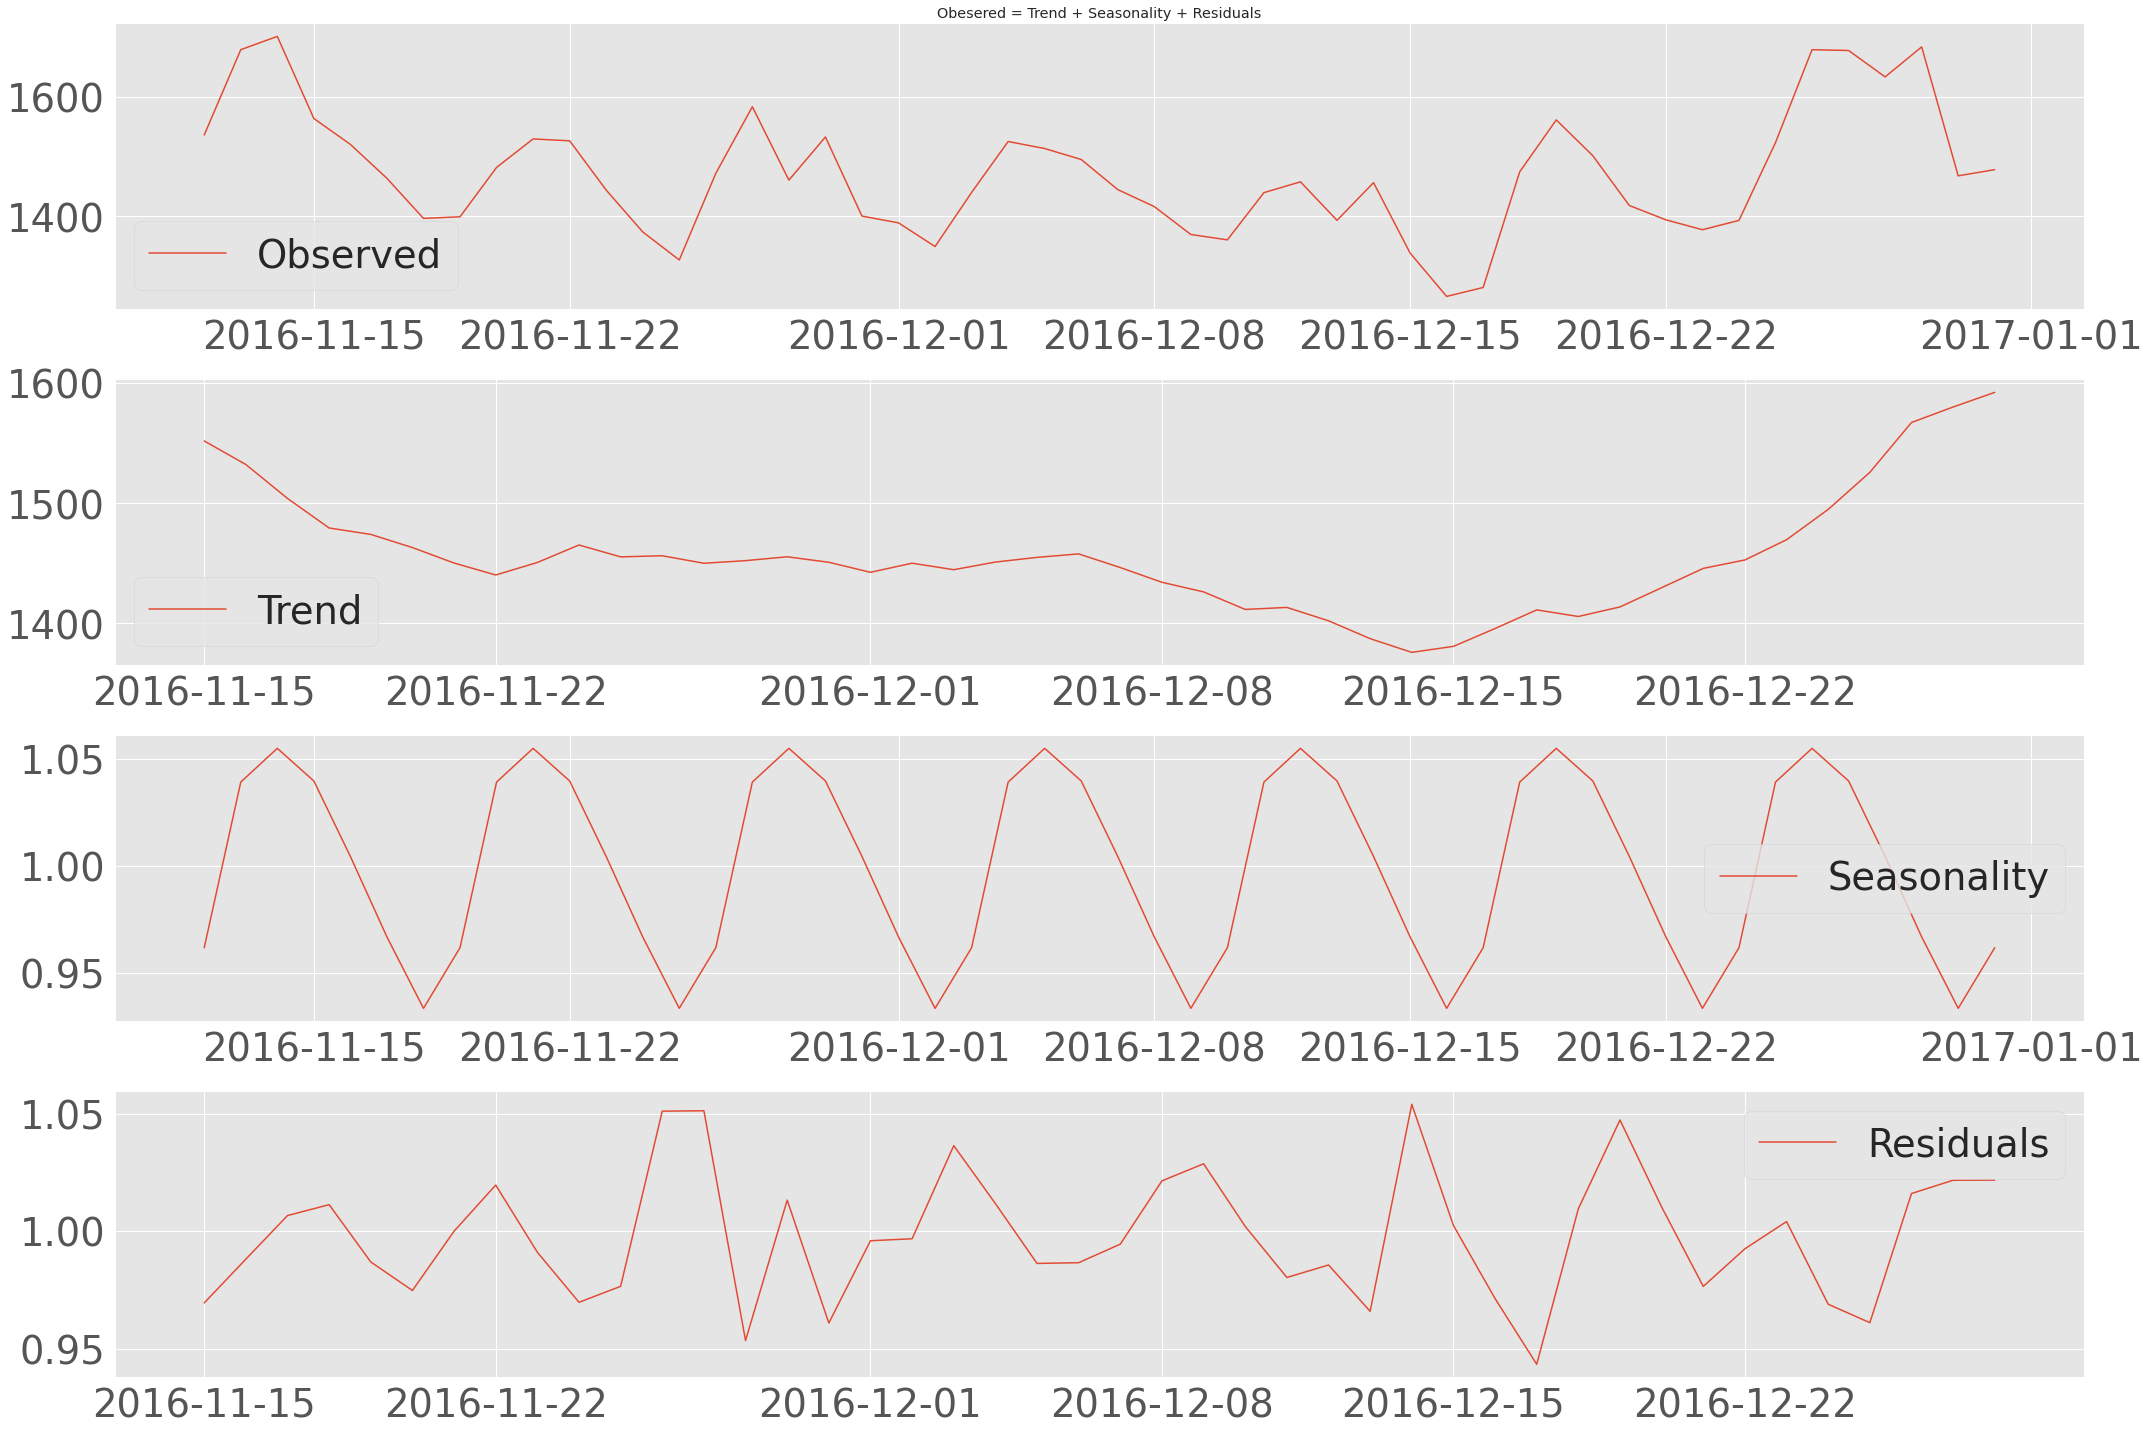

In [40]:
# Naive decomposition of our Time Series as explained above
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 30, 20

plt.subplot(411)
plt.title('Obesered = Trend + Seasonality + Residuals')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles). A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line.A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time. In ou example we can see it is not a linear model. So it is the reason why we use a multiplicative model.


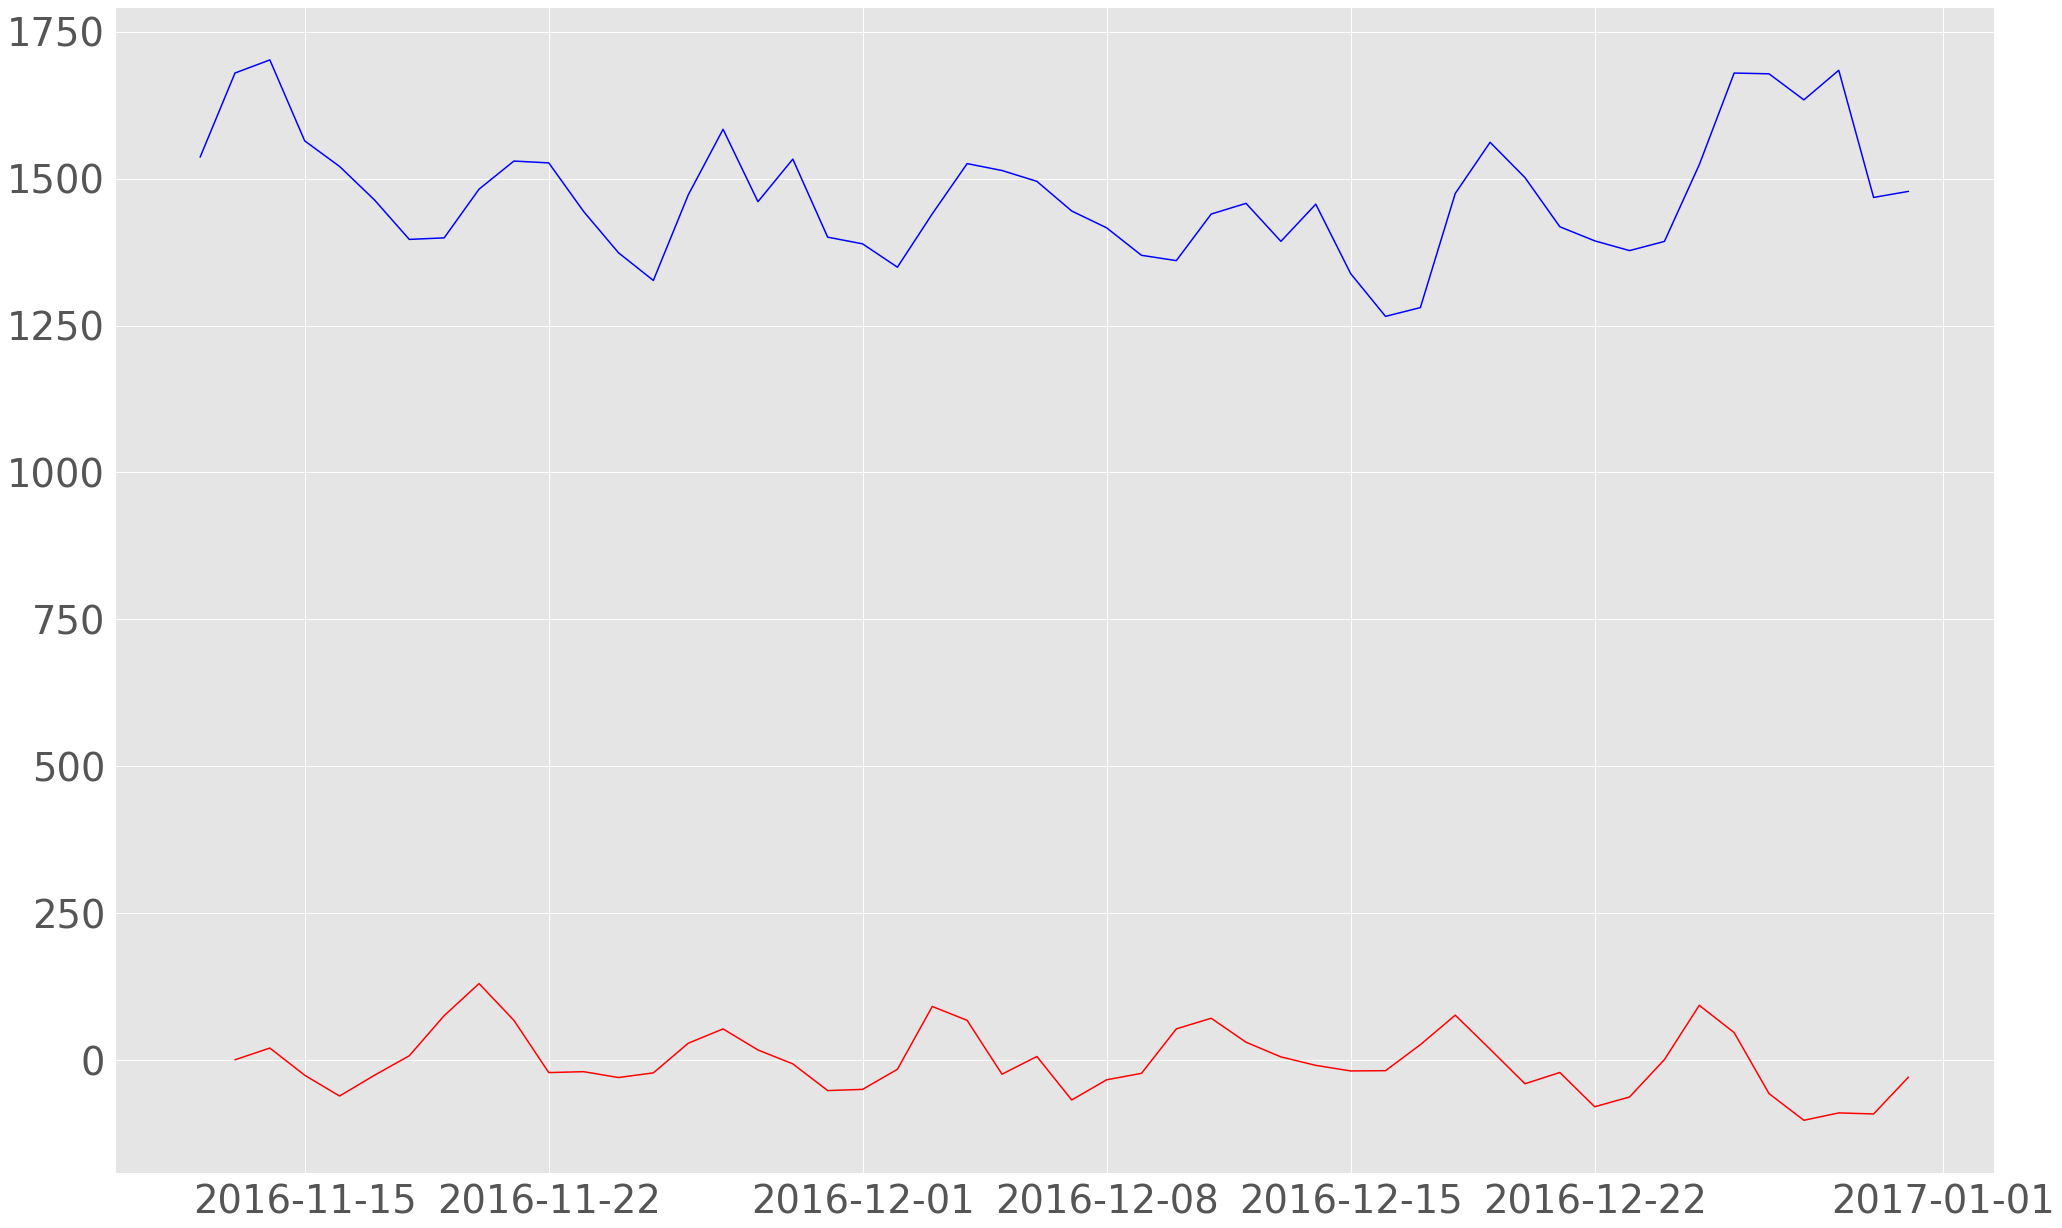

In [41]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_date_index, order=(7, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(df_date_index, color = 'blue')
plt.plot(results_AR.fittedvalues, color='red')
plt.show()
